### ANÁLISIS DE SERIES DE TIEMPO (VARIACIÓN DE VALOR DE DIFERENTES MONEDAS)

Considerando un dataset extraído de la api "oanda", que contiene el histórico de la variación por hora del valor de diferentes pares de monedas (EUR-USD, AUD-USD, etc), se propone lo siguiente: 

* Desarrollar un modelo ARIMA que permita predecir el precio de las monedas en días futuros (forecasting). 
sólo para una moneda por ejemplo, Euro - Dólar.



* Desarrollar un modelo ARMA que permita predecir el precio de las monedas en días futuros (forecasting). 

* Desarrollar un modelo de clasificación para determinar regímenes de mercado.  

## 1. Lectura del Dataframe 

In [1]:
import pandas as pd
import os

In [3]:
datos = pd.read_csv(r'AUD_USD_H1.csv',index_col= 'time')
print(f'El dataframe que se construye con las variaciones de cotización de moneda está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

datos.head(5)

El dataframe que se construye con las variaciones de cotización de moneda está compuesto por 8 columnas y 50000 filas


,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [4]:
datos.shape

(50000, 8)

* Descripción del Dataframe.

* time: Hora en de apertura para cada periodo.

open_bid : Precio de apertura para la venta  a la hora indicada. 

high_bid : Precio más alto de venta del usuario para esa hora. 

low_bid : Precio más bajo de venta del usuario para esa hora.

close_bid: Precio de cierre para la venta a la hora indicada.

open_ask : Precio de apertura para la compra a la hora indicada. 

high_ask : Precio más alto de compra para el usuario para esa hora. 

low_ask : Precio más bajo de compra para usuario para esa hora.

close_ask : Precio de cierre para la compra a la hora indicada.

In [5]:
# Lista de todos los .csv de datos 
path = os.getcwd() 
files = [os.path.join(path, file) for file in os.listdir(path) if '.csv' in file]

# Generación de DataFrame
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# Colocar columna time como índice del DataFrame
df.index = df.time

# Eliminar columna y definición de DataFrame a utilizar
datos = df.drop(['time'], axis = 1)
datos.head()

,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [6]:
datos.shape

(350000, 8)

* Calcular con todas las monedas el retorno (precio actual - precio del pasado), y luego de ello construir una regresión lineal buscando discernir si el retorno de varias monedas (features) logra explicar el retorno de una combinación de moneda (target)

## Construcción modelo ARIMA

# Variación Dolar Euro

In [18]:
datos_euro_dolar = pd.read_csv(r'EUR_USD_H1.csv')
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos_euro_dolar.shape[1]} columnas y {datos_euro_dolar.shape[0]} filas') 

#print(datos_euro_dolar.head())

datos_euro_dolar_ARIMA = datos_euro_dolar[['open_bid', 'time']]
datos_euro_dolar_ARIMA.head()

El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por 9 columnas y 50000 filas


,open_bid,time
0,1.13343,2015-01-28 02 AM
1,1.13335,2015-01-28 03 AM
2,1.13399,2015-01-28 04 AM
3,1.13358,2015-01-28 05 AM
4,1.13544,2015-01-28 06 AM


In [20]:
datos_euro_dolar_ARIMA.index = datos_euro_dolar_ARIMA.time
exchange_rate = datos_euro_dolar_ARIMA.drop(['time'], axis = 1)
exchange_rate.head()

,open_bid
time,
2015-01-28 02 AM,1.13343
2015-01-28 03 AM,1.13335
2015-01-28 04 AM,1.13399
2015-01-28 05 AM,1.13358
2015-01-28 06 AM,1.13544


In [21]:
# Para conocer la distribución de los datos 
exchange_rate.describe()

,open_bid
count,50000.000000
mean,1.127106
std,0.053942
min,0.953880
25%,1.094008
50%,1.125215
75%,1.169330
max,1.254860


<AxesSubplot: xlabel='time'>

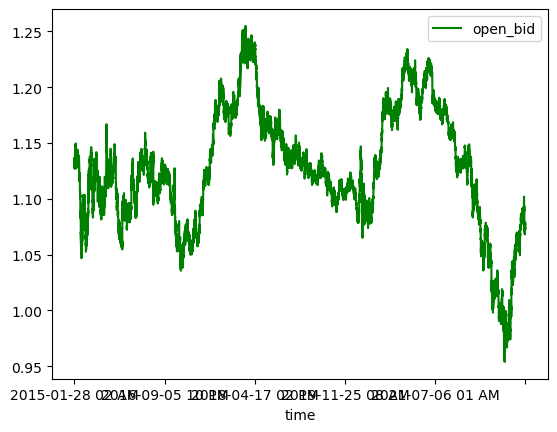

In [22]:
exchange_rate.plot(color = 'green')

array([[<AxesSubplot: title={'center': 'open_bid'}>]], dtype=object)

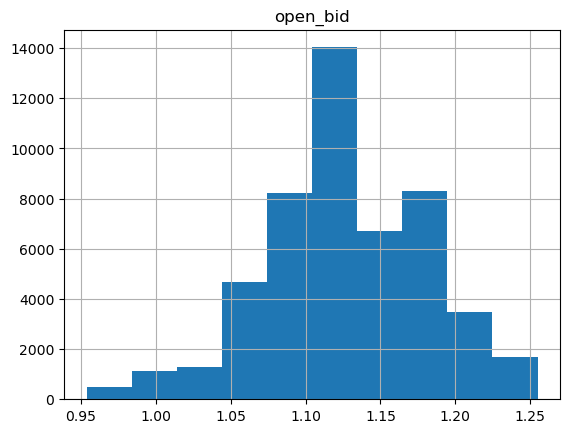

In [23]:
exchange_rate.hist()

<AxesSubplot: xlabel='time'>

<Figure size 1000x900 with 0 Axes>

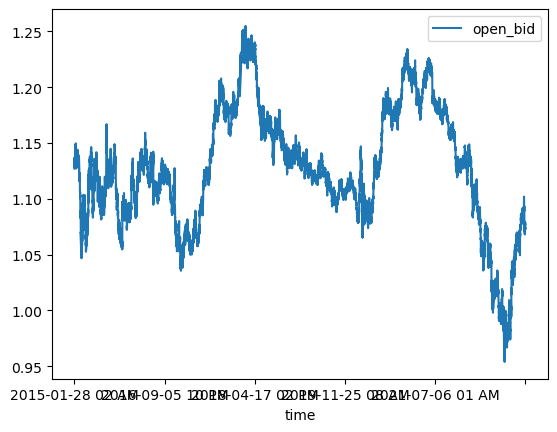

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
exchange_rate.plot()